In [62]:
# Requires 0.24
import os
import sys
sys.path.insert(1,os.path.abspath('../0. Not_git/Sources/scikit-learn/0.24.0'))
import sklearn
print(sklearn.__version__)
#this will be 0.24.2 

0.24.0


### Import libraries

In [86]:
# Modules
import math
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import pandas as pd

# Metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Autoregressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg

# Hyperparameter Grid search
from skforecast.model_selection import grid_search_forecaster

# Backtesting
from skforecast.model_selection import backtesting_forecaster

# Models
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor 
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor

# Preprocessing
from sklearn.preprocessing import StandardScaler

import plotly.io as pio

In [64]:
# To render plotly into GitHub
pio.renderers.default = "svg"

In [65]:
# Select country in analysis ('FIN', 'DEN', 'NOR', 'SWE')
country = 'NOR'

# Dependant variable (TIV or Orders)
dep_var = 'Orders'

# Metrics
metrics = pd.DataFrame()

steps = 24  # Number of months of testing

include_exog = True

### Load Data

In [66]:
# Input path and filename
path = '../5. Master_thesis/Datasets/Output_files/'

# Load files into a pandas dataframes
file = path + '0.xlsx'
df = pd.read_excel(file, sheet_name=country)

# Set index
df = df.set_index("Date")
df.index = pd.PeriodIndex(df.index, freq="M")

# Feature engineering - Seasonal patterns
df['Quarter'] = pd.PeriodIndex(df.index, freq='Q').quarter

# Load files into a pandas dataframes
file = path + 'target.xlsx'
df_nordics = pd.read_excel(file, sheet_name=dep_var)

# Set index
df_nordics = df_nordics.set_index("Date")
df_nordics.index = pd.PeriodIndex(df_nordics.index, freq="M")

#Merge dataframes
df = pd.merge(df, df_nordics[df_nordics.columns.difference([country])], left_index=True, right_index=True)

df.index = df.index.to_timestamp()

# Split data
train = df[:-steps]
test  = df[-steps:]

# Select input and target variables
X_train = train.drop(dep_var, axis=1)
y_train = train[dep_var]

X_test = test.drop(dep_var, axis=1)
y_test = test[dep_var]

start=len(train)
end=len(train)+len(test)-1

print(f"Dataset length : (n={len(df)})")
print('\nData shape:', train.shape, test.shape)
print('\nTrain shape:', X_train.shape, y_train.shape)
print('\nTest shape:', X_test.shape, y_test.shape)
print(f"Train dates    : {train.index.min()} --- {train.index.max()}  (n={len(train)})")
print(f"Test dates     : {test.index.min()} --- {test.index.max()}  (n={len(test)})")

Dataset length : (n=204)

Data shape: (180, 9) (24, 9)

Train shape: (180, 8) (180,)

Test shape: (24, 8) (24,)
Train dates    : 2006-01-01 00:00:00 --- 2020-12-01 00:00:00  (n=180)
Test dates     : 2021-01-01 00:00:00 --- 2022-12-01 00:00:00  (n=24)


In [67]:
df

,Orders,CPI,UR,LTIR,TIV,Quarter,DEN,FIN,SWE
Date,,,,,,,,,
2006-01-01,233,1.847291,4.3,3.65,10606,1,161,1124,110
2006-02-01,270,2.583026,4.3,3.72,10271,1,250,1079,303
2006-03-01,406,2.325581,3.9,3.84,13310,1,468,1210,634
2006-04-01,356,2.679659,4.0,4.07,11062,2,412,1147,1097
2006-05-01,553,2.305825,3.9,4.17,13930,2,550,1001,926
...,...,...,...,...,...,...,...,...,...
2022-08-01,347,6.534824,3.6,2.99,15512,3,343,254,744
2022-09-01,295,6.893617,3.4,3.34,17369,3,337,228,666
2022-10-01,413,7.508533,3.2,3.54,14825,4,322,188,711


In [68]:
# Define exogenous variables
if include_exog:
    df_exo = df[df.columns.difference([dep_var])]
    train_exo = train[train.columns.difference([dep_var])]
    test_exo = test[test.columns.difference([dep_var])]
else:
    df_exo = df.index.to_frame()
    train_exo = train.index.to_frame()
    test_exo = test.index.to_frame()
    df_exo.drop(['Date'], axis=1, inplace=True)
    test_exo.drop(['Date'], axis=1, inplace=True)    
    train_exo.drop(['Date'], axis=1, inplace=True)

print('\nData shape:', train.shape, test.shape)
print('Exog shape:', train_exo.shape, test_exo.shape)


Data shape: (180, 9) (24, 9)
Exog shape: (180, 8) (24, 8)


In [69]:
df_exo

,CPI,DEN,FIN,LTIR,Quarter,SWE,TIV,UR
Date,,,,,,,,
2006-01-01,1.847291,161,1124,3.65,1,110,10606,4.3
2006-02-01,2.583026,250,1079,3.72,1,303,10271,4.3
2006-03-01,2.325581,468,1210,3.84,1,634,13310,3.9
2006-04-01,2.679659,412,1147,4.07,2,1097,11062,4.0
2006-05-01,2.305825,550,1001,4.17,2,926,13930,3.9
...,...,...,...,...,...,...,...,...
2022-08-01,6.534824,343,254,2.99,3,744,15512,3.6
2022-09-01,6.893617,337,228,3.34,3,666,17369,3.4
2022-10-01,7.508533,322,188,3.54,4,711,14825,3.2


### Backtesting

In [91]:
end

203

In [92]:
def backtest(model_name, forecaster):
    metric, backtest_pred = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = df[dep_var],
                                    exog               = df_exo,
                                    initial_train_size = 24,
                                    fixed_train_size   = False,
                                    steps              = 6,
                                    interval           = [5, 95],
                                    refit              = True,
                                    metric             = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error'],
                                    verbose            = True
                                 )
         
    # Calculate metrics
    mae = metric[1]                                                     # MAE (Mean Absolute Error)
    #mse = metric[0]                                                    # MSE (Mean Squared Error)
    rmse = math.sqrt(metric[0])                                         # RMSE (Root Mean Squared Error)    
    mape = metric[2] * 100                                              # MAPE
    accuracy = 100 - mape                                               # Accuracy
    
    # Print metrics
    print(model_name, 'Backtesting:')                                   # Model name
    print('Mean Absolute Error: {:0.2f}.'.format(mae))                  # MAE    
    print('Root Mean Squared Error: {:0.2f}.'.format(rmse))             # RMSE      
    print('Mean Absolute Percentage Error: {:0.2f}%.'.format(mape))     # MAPE 
    print('Accuracy = {:0.2f}%.'.format(accuracy))                      # Accuracy

    # Append metrics for summary
    metrics[model_name] = [mae, rmse, mape, accuracy]
    metrics.index = ['MAE', 'RMSE', 'MAPE', 'Accuracy']   

    backtest_pred.head()
    
    # Plot
    fig = go.Figure()
    fig.add_trace(go.Scatter(dict(x=backtest_pred.index, y=df[dep_var], mode='lines', name= 'Train')))
    fig.add_trace(go.Scatter(dict(x=backtest_pred.index, y=backtest_pred.pred, mode='lines', name= 'Predictions')))

    fig.add_trace(go.Scatter(x=backtest_pred.index, y=backtest_pred['upper_bound'], fill='tonexty')) # fill to trace0

    fig.update_layout(height=500, width=1200, title_text=model_name + " Backtesting in " + country)    
    fig.show()


    fig, ax=plt.subplots(figsize=(9, 4))
    #df[dep_var].plot(ax=ax, label='test')
    backtest_pred['pred'].plot(ax=ax, label='predictions')
    ax.plot(backtest_pred.index,df[dep_var], label='test')
    ax.fill_between(
        backtest_pred.index,
        backtest_pred['lower_bound'],
        backtest_pred['upper_bound'],
        color = 'red',
        alpha = 0.2,
        label = 'prediction interval'
    )
    ax.legend();    

Information of backtesting process
----------------------------------
Number of observations used for initial training: 24
Number of observations used for backtesting: 180
    Number of folds: 30
    Number of steps per fold: 6

Data partition in fold: 0
    Training:   2006-01-01 00:00:00 -- 2007-12-01 00:00:00  (n=24)
    Validation: 2008-01-01 00:00:00 -- 2008-06-01 00:00:00  (n=6)
Data partition in fold: 1
    Training:   2006-01-01 00:00:00 -- 2008-06-01 00:00:00  (n=30)
    Validation: 2008-07-01 00:00:00 -- 2008-12-01 00:00:00  (n=6)
Data partition in fold: 2
    Training:   2006-01-01 00:00:00 -- 2008-12-01 00:00:00  (n=36)
    Validation: 2009-01-01 00:00:00 -- 2009-06-01 00:00:00  (n=6)
Data partition in fold: 3
    Training:   2006-01-01 00:00:00 -- 2009-06-01 00:00:00  (n=42)
    Validation: 2009-07-01 00:00:00 -- 2009-12-01 00:00:00  (n=6)
Data partition in fold: 4
    Training:   2006-01-01 00:00:00 -- 2009-12-01 00:00:00  (n=48)
    Validation: 2010-01-01 00:00:00 -- 201

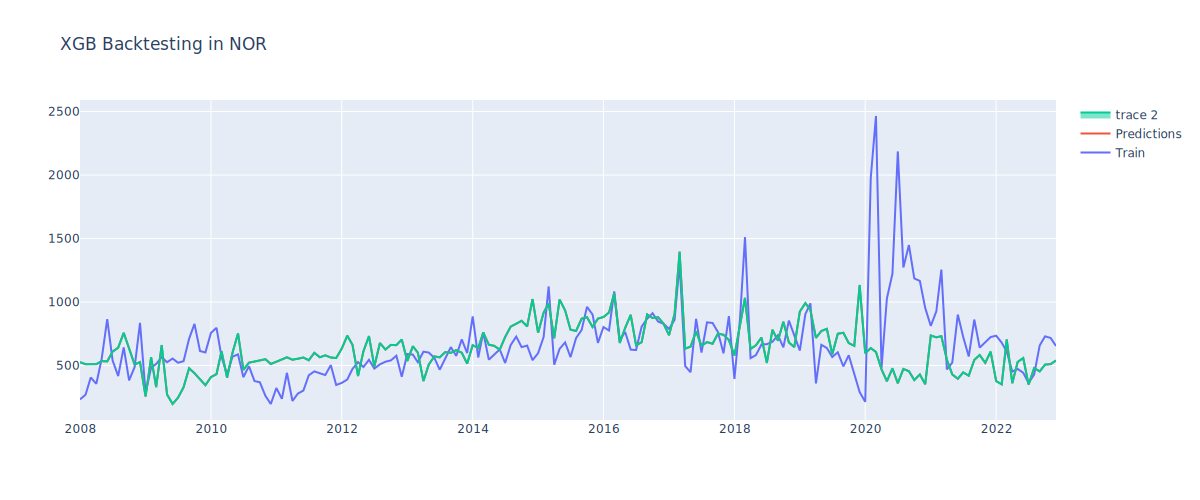

    feature  importance
17      SWE    0.477477
3     lag_4    0.110085
1     lag_2    0.080523
2     lag_3    0.067613
10   lag_11    0.049627
13      DEN    0.049370
14      FIN    0.034041
0     lag_1    0.021082
11   lag_12    0.018271
12      CPI    0.013724
18      TIV    0.011399
7     lag_8    0.009989
15     LTIR    0.008883
16  Quarter    0.008847
8     lag_9    0.007363
19       UR    0.007362
5     lag_6    0.007306
6     lag_7    0.006472
9    lag_10    0.005699
4     lag_5    0.004869 



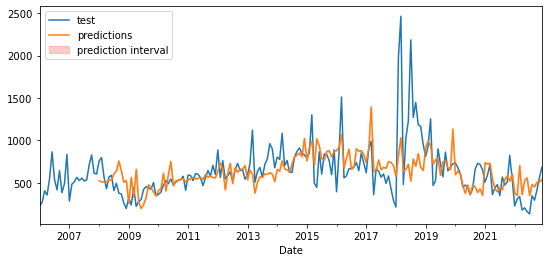

In [93]:
# Models
modelclasses = [
#    ["Ada", AdaBoostRegressor],
#    ["GB", GradientBoostingRegressor],    
    ["XGB", XGBRegressor],
#    ["LGBM", LGBMRegressor],    
#    ["RF", RandomForestRegressor],
#    ["ET", ExtraTreesRegressor],
]

number_of_lags = 12   # Number of lags 

for model_name, Model in modelclasses:
    
    # Create forecaster
    forecaster = ForecasterAutoreg(
            regressor = Model(),
            lags = number_of_lags,
            transformer_y = StandardScaler()

    )
    
    # Fit model
    forecaster.fit(y=train[dep_var], exog=train_exo)    
        
    # Predict
    preds = forecaster.predict(steps=steps, exog=test_exo)
    
    # Backtest
    backtest(model_name, forecaster)

    # Feature importance
    feature_importance = forecaster.get_feature_importance().sort_values(by='importance', ascending=False)
    print(feature_importance, "\n")

In [72]:
def plot_metrics(m, w, h, error: bool):

    chart = m.transpose()
    if error:
        chart.drop(['Accuracy'], axis=1, inplace=True)
    else:
        chart.drop(['MAE', 'RMSE', 
                    'MAPE'], axis=1, inplace=True)
    ax = chart.plot.bar(title="Models Performance (" + country + ' /  ' 
            + dep_var + ')',
            figsize=(w, h))        
    for c in ax.containers:        
        ax.bar_label(c, fmt='%0.2f', label_type='edge', padding=5)
    ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

### Summary

In [73]:
metrics

,XGB,Ridge
MAE,172.554444,196.155326
RMSE,274.709049,303.920464
MAPE,30.902410,33.221795
Accuracy,69.097590,66.778205


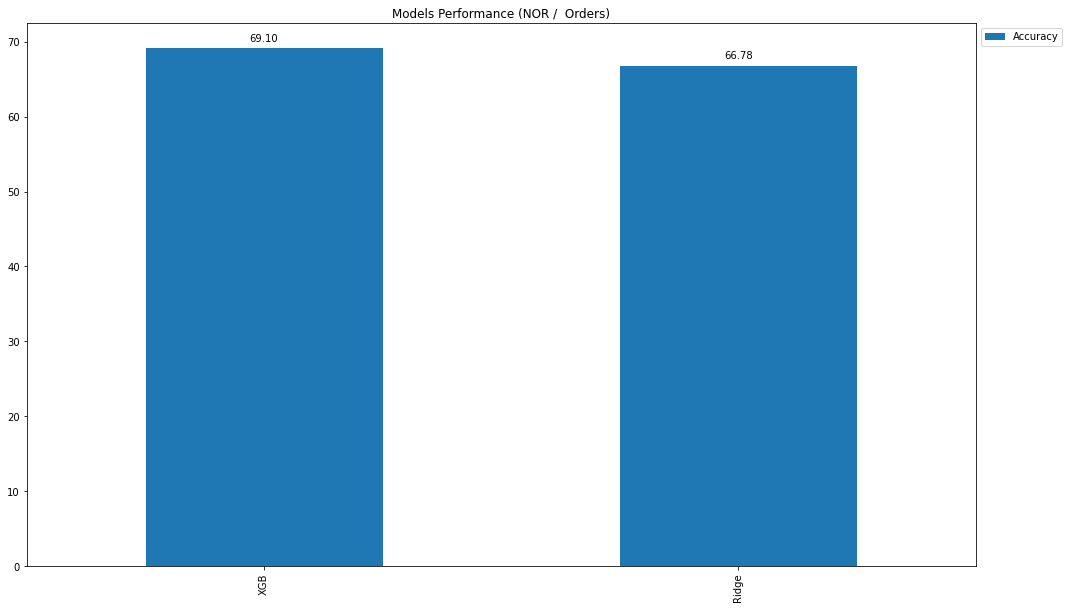

In [74]:
plot_metrics(metrics, 17, 10, False)

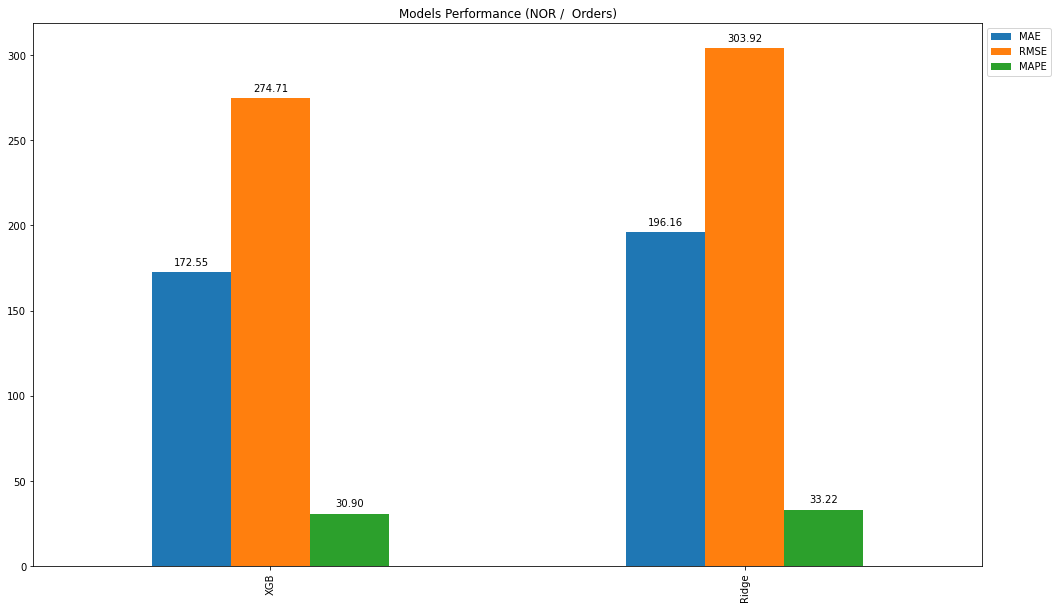

In [75]:
plot_metrics(metrics, 17, 10, True)